# Homework 1 



### Instructions
Download this jupyer notebook (button at the top of the page or download from the Github repository). Provide your answers as Markdown text, Python code, and/or produce plots as appropriate. The notebook should run all the cells in order without errors.  
Submit both the `.ipynb` and a `.pdf` to Canvas.

Make sure the `.pdf` has all the relevant outputs showing. To save as `.pdf` you can first export the notebook as `.html`, open it in a browers and then "Print to PDF". 

**NOTE:** As we will be sharing the files for peer grading, please keep your submission anonymous.

In [4]:
import abc
from typing import Callable
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import functools
import cvxpy as cp

## Problem 1
In this problem, you will familiarize yourself with the basic operations with dynamical systems and useful JAX operations.

Given the following dynamics class below.

In [5]:
class Dynamics(metaclass=abc.ABCMeta):
    dynamics_func: Callable
    state_dim: int
    control_dim: int

    def __init__(self, dynamics_func, state_dim, control_dim):
        self.dynamics_func = dynamics_func
        self.state_dim = state_dim
        self.control_dim = control_dim

    def __call__(self, state, control, time=0):
        return self.dynamics_func(state, control, time)

### (a) Setting up dynamics
Using the `Dynamics` class, construct the continuous time dynamics for the dynamically extended unicycle model.

$$
    \dot{\mathbf{x}} = \begin{bmatrix}
        \dot{x} \\ \dot{y} \\ \dot{\theta} \\ \dot{v}
    \end{bmatrix} = \begin{bmatrix}
        v\cos\theta \\ v\sin\theta \\ \omega \\ a
    \end{bmatrix}, \qquad u=(\omega, a)
$$

In [6]:
def dynamic_unicycle_ode(state, control, time):
    '''
    Unicycle dynamics: state = [x, y, theta, v] and control = [w, a]
    '''
    x, y, theta, v = state
    w, a = control
    
    x_dot = v*jnp.cos(theta)
    y_dot = v*jnp.sin(theta)
    theta_dot = w
    v_dot = a
    
    
    return jnp.array([x_dot, y_dot, theta_dot, v_dot]) # update this line


state_dim = 4
control_dim = 2
continuous_dynamics = Dynamics(dynamic_unicycle_ode, state_dim, control_dim)   #this gives the ODE dx/dt

### (b) Obtaining discrete-time dynamics

With the continuous time dynamics, we can obtain the discrete time dynamics by integrating over a time step $\Delta t$.

Implement both Euler integation and Runge-Kutta integration to obtain the discrete-time dynamics.

In [7]:
def euler_integrate(dynamics, dt):
    # zero-order hold
    def integrator(x, u, t):
        dx = dynamics(x,u,t)
        return jnp.array(x+dt*dx) # computes x(k+1) using euler inteegration x(k+1) = dx(k)*dt + x(k)

    return integrator



def runge_kutta_integrator(dynamics, dt=0.1):
    # zero-order hold
    def integrator(x, u, t):
        k1 = dynamics(x,u,t)
        k2 = dynamics(x + 0.5*dt*k1, u, t+0.5*dt)
        k3 = dynamics(x + 0.5*dt*k2, u, t+0.5*dt)
        k4 = dynamics(x + dt*k3, u, t+dt)
        
        return jnp.array(x + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)) # computes x(k+1) using RK4 integration

    return integrator

In [8]:
# example usage of the integrators

dt = 0.1 # timestep size

discrete_dynamics_euler = Dynamics(
    euler_integrate(continuous_dynamics, dt), state_dim, control_dim
)
discrete_dynamics_rk = Dynamics(
    runge_kutta_integrator(continuous_dynamics, dt), state_dim, control_dim
)

### (c) Simulating dynamics

Simulate your dynamics over 5 seconds for different values of $\Delta t$ and compare the trajectories. 

Show on the same plot, the simulated trajectories for the following cases:
- Discrete-time dynamics with Euler integration, $\Delta t = 0.01$
- Discrete-time dynamics with Euler integration, $\Delta t = 0.5$
- Discrete-time dynamics with RK integration, $\Delta t = 0.01$
- Discrete-time dynamics with RK integration, $\Delta t = 0.5$

How does the choice of integration scheme and time step size influence the resulting trajectories? Feel free to try different time step values, but you don't need to submit plots of them.

Text(0, 0.5, 'y [m]')

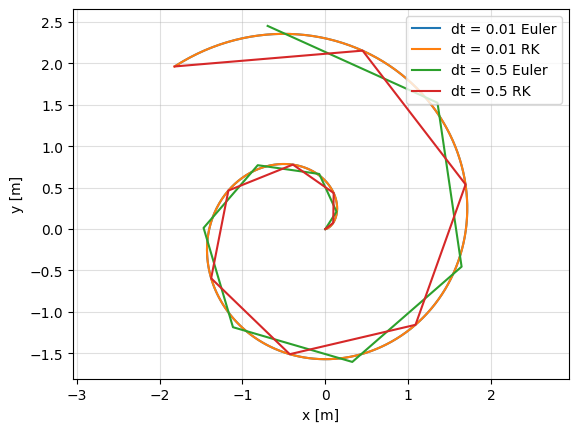

In [9]:
def simulate(dynamics, initial_state, controls, dt):
    
   #  Propagates states through the dynamics using the control sequence, starting at initial_state.
    
   # Args:
   #     dynamics: A function that takes in a state and control, and returns the next state.
   #     initial_state: A jax.numpy array of size (n,) representing the initial state.
   #     controls: A jax.numpy array of size (T, m), where T is the number of control inputs.
   #     dt: A scalar that represents the time step for integration (important for Euler and Runge-Kutta methods).
   # Returns:
   #     A jax.numpy array of size (T+1, n), representing the sequence of states over time, including the initial state and the state at each time step.

   #  Initialize the state list with the initial state
    trajectory = [initial_state]
    state = initial_state

    # Iterate through the control sequence and compute the next state at each step
    for u in controls:
        state = dynamics(state, u, dt)  # Get next state from dynamics
        trajectory.append(state)  # Append new state to the trajectory list
    
    # Stack the trajectory list into a jnp array of shape (T+1, n)
    return jnp.stack(trajectory)

# code to loop over the different integrators and step sizes
# and plot the corresponding trajectories

initial_state = jnp.array([0.0, 0.0, 0.0, 0.0])
control = jnp.array([2.0, 1.0])  # constant control over the 5 second duration.
duration = 5.0
dts = [0.01, 0.5]

for dt in dts:
    num_steps = int(duration / dt)
    controls = [control] * num_steps
    
    # construct the discrete dynamics for given timestep
    discrete_dynamics_euler = Dynamics(
        euler_integrate(continuous_dynamics, dt), state_dim, control_dim
    )
    discrete_dynamics_rk = Dynamics(
        runge_kutta_integrator(continuous_dynamics, dt), state_dim, control_dim
    )
    
    # simulate dynamics
    xs_euler = simulate(discrete_dynamics_euler, initial_state, controls, dt)
    xs_rk = simulate(discrete_dynamics_rk, initial_state, controls, dt)

    # plot the trajectories
    plt.plot(xs_euler[:, 0], xs_euler[:, 1], label=f"dt = {dt} Euler")
    plt.plot(xs_rk[:, 0], xs_rk[:, 1], label=f"dt = {dt} RK")
    plt.legend()
    
plt.grid(alpha=0.4)
plt.axis("equal")
plt.xlabel("x [m]")
plt.ylabel("y [m]")


### (d) `jax.vmap` 
Suppose now that you want to simulate *many* trajectories. Rather than wrapping the `simulate` function in a for loop, we can use `jax.vmap` which is a *vectorize map* function, allowing us to apply a function, in this case `simulate` over multiple inputs.

An example usage of how to use the `jax.vmap` is shown below. Notice that we can specify which argument should be vectorized and along which dimension.

In [10]:
def foo(x, y, z):
    return x + y + z

N = 1000
x = jnp.array(np.random.randn(N))
y = jnp.array(np.random.randn(N))
z = jnp.array(np.random.randn(N))

xs = jnp.array(np.random.randn(N, N))
ys = jnp.array(np.random.randn(N, N))
zs = jnp.array(np.random.randn(N, N))

foo(x, y, z)  # non-vectorized version
# vectorized version for all inputs, 0 is the batch dimension for all inputs
jax.vmap(foo, in_axes=[0, 0, 0])(xs, ys, zs)  

# x not batched, but ys and zs are with 0 as the batch dimension
jax.vmap(foo, in_axes=[None, 0, 0])(x, ys, zs)  

# y not batched, but xs and zs are with 0 as the batch dimension
jax.vmap(foo, in_axes=[0, None, 0])(xs, y, zs)  

# z not batched, but xs and ys are with 0 as the batch dimension
jax.vmap(foo, in_axes=[0, 0, None])(xs, ys, z)  

# x and y not batched, but zs is with 0 as the batch dimension
jax.vmap(foo, in_axes=[None, None, 0])(x, y, zs)  

# vectorized version for all inputs, batch dimension for xs is 1, 
# while 0 is the batch dimension for yx and zs
jax.vmap(foo, in_axes=[1, 0, 0])(xs, ys, zs)  



Array([[ 1.2015691 , -1.5880075 , -1.5389504 , ..., -0.81378734,
         2.3726118 ,  1.7764227 ],
       [-0.4727105 ,  0.506736  , -0.26793242, ...,  1.3905163 ,
        -4.829337  ,  0.9437952 ],
       [-0.40734017,  0.17948234,  0.70705914, ..., -2.3282592 ,
         1.5043988 , -2.6010373 ],
       ...,
       [-1.0473037 , -1.6948273 ,  0.5862818 , ...,  0.7211764 ,
         0.16427541,  0.84204906],
       [ 1.0633695 , -0.14851941,  0.25203097, ..., -0.95566064,
        -1.0546839 , -1.2097971 ],
       [-0.46365637,  1.6060605 , -0.7228626 , ..., -1.171991  ,
         0.05492225, -0.08747214]], dtype=float32)

Apply `jax.vmap` for the simulate function for the following batch of initial states and control inputs
Choose $\Delta t = 0.1$.
Use the following values and simulate multiple trajectories using the `jax.vmap` function.


Trajs shape: (1000, 51, 4)


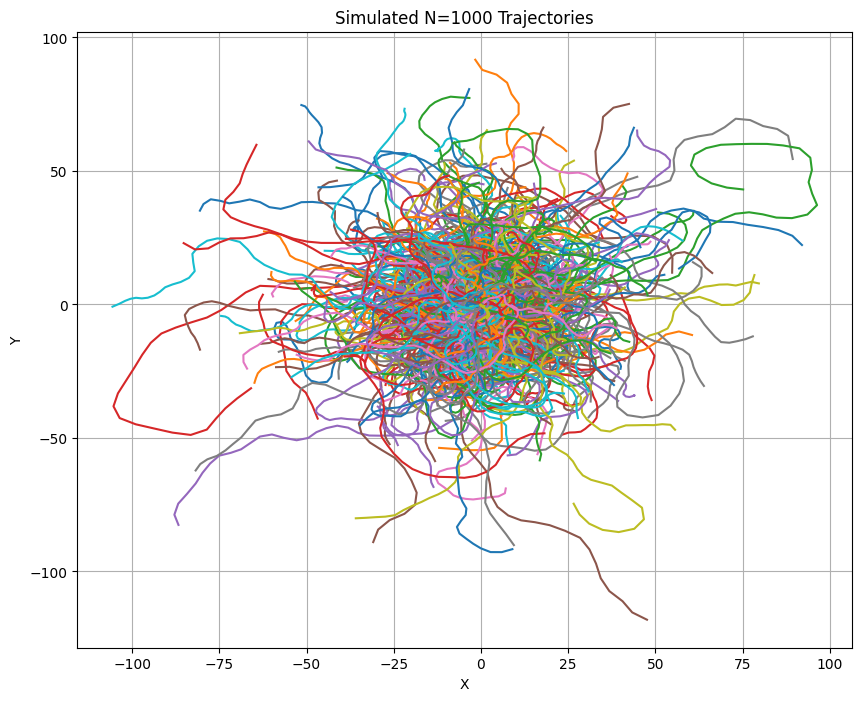

In [11]:
state_dim = continuous_dynamics.state_dim
control_dim = continuous_dynamics.control_dim
N = 1000
n_time_steps = 50
dt = 0.1

#initial_states = jnp.array([0.0, 0.0, 0.0, 0.0])
#controls = jnp.array([2.0, 1.0])  
#initial_states = jnp.array(np.random.randn(N, state_dim))
#controls = jnp.array(np.random.randn(N, n_time_steps, control_dim))

# Create random initial states and controls
initial_states = jnp.array(np.random.randn(N, state_dim))
controls = jnp.array(np.random.randn(N, n_time_steps, control_dim))

# Overwrite the first initial state and first control sequence to verify previous results
initial_states = initial_states.at[0].set(jnp.array([0.0, 0.0, 0.0, 0.0]))
controls = controls.at[0].set(jnp.tile(jnp.array([2.0, 1.0]), (n_time_steps, 1)))

# trajs = # initial_states[None,...] # update this line
#trajs = jax.vmap(simulate, in_axes=[None, 0, 0, None])(discrete_dynamics_euler, initial_states, controls, dt)    #Euler method
trajs = jax.vmap(simulate, in_axes=[None, 0, 0, None])(discrete_dynamics_rk, initial_states, controls, dt)

#Vectorizing simulate across the batch dimension (size N) of initial_states and controls.
#Keeping continuous_dynamics and dt shared (non-batched) across all calls (None in in_axes).
#Result:This computes multiple simulations in parallel — one per (initial_state, control) pair. 
#       trajs will have shape (N, T+1, state_dim), where T = n_time_steps.

print("Trajs shape:", trajs.shape)

    
# plot to visualize all the trajectories
# Plot the trajectories for the first few instances in the batch
plt.figure(figsize=(10, 8))
for i in range(N):  # Plot up to 10 trajectories
    plt.plot(trajs[i, :, 0], trajs[i, :, 1])
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Simulated N=1000 Trajectories')
plt.grid(True)
plt.show()


### (e) `jax.jit` (optional reading)

Bleh! You notice that it takes some time to run it. And if you increased the duration or number of trajectories to simulate, the computation would increase.
If only we could compile the code to help reduce computation time. With JAX, you can! We can use the `jax.jit` function that performs just-in-time compilation. JAX will figure out the expected sizes of the input arrays and allocate memory based on that.

There are number of ways to just `jax.jit`, and it can get a bit tricky as your code becomes more complex. Best to read up the JAX documentation for more information.
But for relatively simple functions, you can usually just apply `jax.jit` without any fuss, and get significant speedup in your code.

Uncomment the following cells to see the computational benefits of `jax.jit`.

In [12]:
# without jitting
%timeit jax.vmap(simulate, in_axes=[None, 0, 0, None])(discrete_dynamics_rk, initial_states, controls, jnp.array(dt)).block_until_ready()

2.11 s ± 360 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
# # method 1: directly apply jax.jit over the jax.vmap function
# # need to provide the static_argnums argument to the first argument since that is a function input and not an array input
sim_jit = jax.jit(jax.vmap(simulate, in_axes=[None, 0, 0, None]), static_argnums=0)
        
# # time the run
%timeit sim_jit(discrete_dynamics_rk, initial_states, controls, jnp.array(dt)).block_until_ready()

100 ms ± 5.84 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
# # method 2: apply jax.jit over the simulate function and then apply jax.vmap
sim_jit = jax.jit(simulate, static_argnums=0)
sim_jit_vmap = jax.vmap(sim_jit, in_axes=[None, 0, 0, None])
%timeit sim_jit_vmap(discrete_dynamics_rk, initial_states, controls, jnp.array(dt)).block_until_ready()

49.2 ms ± 6.01 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


55.2 ms ± 7.64 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Trajs_jit shape: (1000, 51, 4)


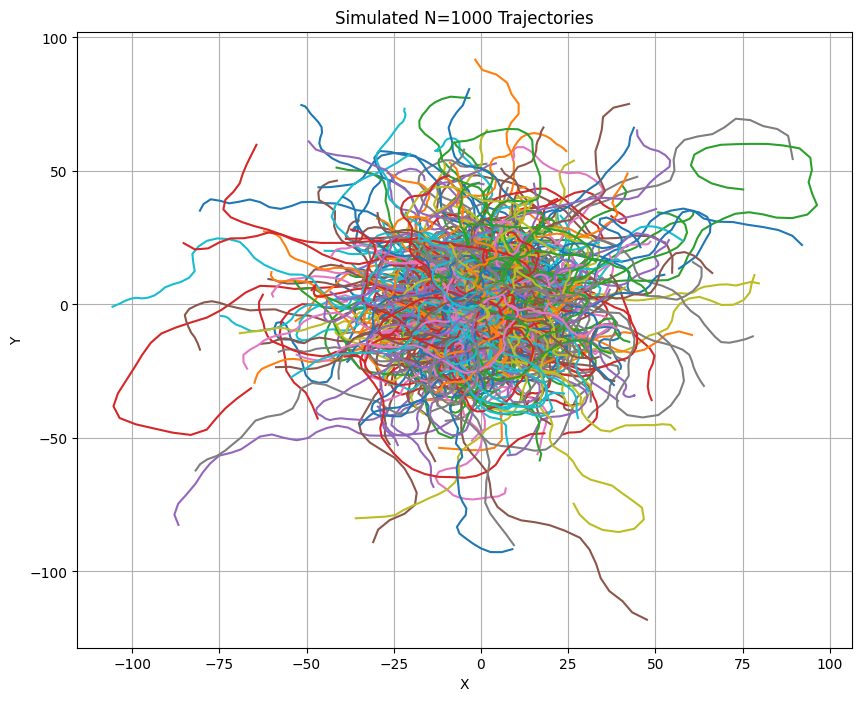

In [15]:
# # method 2: apply jax.jit over the simulate function and then apply jax.vmap
sim2_jit = jax.jit(simulate, static_argnums=0)
sim2_jit_vmap = jax.vmap(sim2_jit, in_axes=[None, 0, 0, None])

# Compute and time it
%timeit trajs_jit = sim2_jit_vmap(discrete_dynamics_rk, initial_states, controls, jnp.array(dt)).block_until_ready()

# Actually run and store the result
trajs_jit = sim2_jit_vmap(discrete_dynamics_rk, initial_states, controls, jnp.array(dt))

print("Trajs_jit shape:", trajs_jit.shape)  # Should be (N, T+1, state_dim)

    
# plot to visualize all the trajectories
# Plot the trajectories for the first few instances in the batch
plt.figure(figsize=(10, 8))
for i in range(N):  # Plot up to 10 trajectories
    plt.plot(trajs_jit[i, :, 0], trajs_jit[i, :, 1])
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Simulated N=1000 Trajectories')
plt.grid(True)
plt.show()

## Problem 2

We continue to consider the dynamically-extended unicycle model and investigate a way to linearize the dynamics around any state. 
First, we will perform the linearization analytically, and then leverage modern computation tools which will be incredibly helpful especially if the dynamics are complicated!
We can efficiently compute gradients via automatic differentiation.
JAX is an automatic differentiation library. 

### (a) Linearize dynamics analytically
Linearize the dynamics given in Problem 1 part (a) about a point $(\mathbf{x}_0, \mathbf{u}_0)$. That is, for linearized dynamics of the form $\dot{\mathbf{x}} \approx A\mathbf{x}+ B\mathbf{u} + C$, give expressions for $A$, $B$, and $C$. 

$A=\ldots = [0 0 -vsintheta cos theta]$

$B=\ldots$

$C=\ldots$

Also code up your analytic expression in `linearize_unicycle_continuous_time_analytic`.

In [16]:
def linearize_unicycle_continuous_time_analytic(state, control,time):
   # Linearizes the continuous time dynamics of the dynamic unicyle using analytic expression
   # Inputs:
   #     state     : A jax.numpy array of size (n,)
   #     control   : A jax.numpy array of size (m,)
   #     time      : A real scalar

   # Outputs:
   #     A : A jax.numpy array of size (n,n)
   #     B : A jax.numpy array of size (n,m)
   #     C : A jax.numpy array of size (n,1)

    # Unpack state and control
    x, y, theta, v = state
    w, a = control
    
    # Jacobian A (state matrix)
    A = jnp.array([
        [0, 0, -v*jnp.sin(theta), jnp.cos(theta)],   # dx/dx, dx/dy, dx/dtheta, dx/dv
        [0, 0, v*jnp.cos(theta), jnp.sin(theta)],    # dy/dx, dy/dy, dy/dtheta, dy/dv
        [0, 0, 0, 0],                                # dtheta/dx, dtheta/dy, dtheta/dtheta, dtheta/dv
        [0, 0, 0, 0]                                 # dv/dx, dv/dy, dv/dtheta, dv/dv
    ])
    
    # Jacobian B (control matrix)
    B = jnp.array([
        [0, 0],  # dx/dw, dx/da
        [0, 0],  # dy/dw, dy/da
        [1, 0],  # dtheta/dw, dtheta/da
        [0, 1]   # dv/dw, dv/da
    ])
    
    # Output matrix C 
    C = jnp.array([
        0, 0, 0, 0  # Output y (position in y) assuming no observable states
    ])
    
    return A, B, C


### (b) Evaluate linearized dynamics (analytic)
Using your answer from 2(a), evaluate $A$, $B$, and $C$ for $\mathbf{x}_0 = [0, 0, \frac{\pi}{4}, 2.]^T$ and $\mathbf{u}_0 = [0.1, 1.]^T$. Give your answer to 2 decimal places.

In [17]:
# add your code here to test the function
x0 = jnp.array([0,0,jnp.pi/4,2])
u0 = jnp.array([0.1,1])

# Get linearized matrices
A, B, C = linearize_unicycle_continuous_time_analytic(x0, u0, 1)

# Round the results to 2 decimal places
A_rounded = jnp.round(A, 2)
B_rounded = jnp.round(B, 2)
C_rounded = jnp.round(C, 2)

# Display results
print("A:", A_rounded)
print("B:", B_rounded)
print("C:", C_rounded)

A: [[ 0.    0.   -1.41  0.71]
 [ 0.    0.    1.41  0.71]
 [ 0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.  ]]
B: [[0 0]
 [0 0]
 [1 0]
 [0 1]]
C: [0 0 0 0]


### (c) Linearize dynamics using JAX autodiff
Time to test out Jax's autodifferentiation capabilities! JAX has an [Autodiff Cookbook](https://docs.jax.dev/en/latest/notebooks/autodiff_cookbook.html) that provides more details about the various autodiff functions, forward vs backward autodiff, jacboians, hessians, and so forth. You are strongly encouraged read through it.

Using Jax and its built-in `jax.jacobian` function, fill in the `linearize_autodiff` function that takes in a dynamics function, and a state and control to linearize about, and returns the $A$, $B$, and $C$ matrices describing the linearized dynamics. Test your function using the continuous-time dynamics with $\mathbf{x}_0 = [0.0, 0.0, \frac{\pi}{4}, 2.0]^T$ and $\mathbf{u}_0 = [0.1, 1.0]^T$ and use the provided test code to verify that the outputs you get from your function are the same as the values you get from `linearize_unicycle_continuous_time_analytic`.

Side note for the curious: the `jnp.allclose` function tests if all corresponding elements of two arrays are within a small tolerance of each other. When working with finite-precision machine arithmetic, you can almost never test two numbers for exact equality directly, because different rounding errors in different computations very often result in very slightly different values even when the two calculations should theoretically result in the same number. For this reason, real numbers in software (which on almost all modern hardware are represented in [IEEE 754 floating-point format](https://en.wikipedia.org/wiki/IEEE_754)) are usually considered to be equal if they are close enough that their difference could be reasonably explained by rounding errors.

In [18]:
def linearize_autodiff(function_name, state, control, time):
    '''
    Linearizes the any dynamics using jax autodiff.
    Inputs:
        function_name: name of function to be linearized. Takes state, control, and time as inputs.
        state     : A jax.numpy array of size (n,); the state to linearize about
        control   : A jax.numpy array of size (m,); the control to linearize about
        time      : A real scalar; the time to linearize about

    Outputs:
        A : A jax.numpy array of size (n,n)
        B : A jax.numpy array of size (n,m)
        C : A jax.numpy array of size (n,1)
    '''

    # Extract the actual dynamics function
    func = function_name.dynamics_func

    # Ensure inputs are JAX-compatible
    state = jnp.array(state)
    control = jnp.array(control)
    time = jnp.array(time)

    # Compute Jacobians
    A = jax.jacobian(func, argnums=0)(state, control, time)
    B = jax.jacobian(func, argnums=1)(state, control, time)
    C = jax.jacobian(func, argnums=2)(state, control, time)
    
    return A, B, C

In [19]:
# test code:
state = jnp.array([0.0, 0.0, jnp.pi/4, 2.])
control = jnp.array([0.1, 1.])
time = 0.

A_autodiff, B_autodiff, C_autodiff = linearize_autodiff(continuous_dynamics, state, control, time)
A_analytic, B_analytic, C_analytic = linearize_unicycle_continuous_time_analytic(state, control, time)

print('A_autodiff:', A_autodiff)
print('A_analytic:', A_analytic)  

print('B_autodiff:', B_autodiff)
print('B_analytic:', B_analytic)  

print('C_autodiff:', C_autodiff)
print('C_analytic:', C_analytic)  
#print("C_analytic shape:", C_analytic.shape)

print('A matrices match:', jnp.allclose(A_autodiff, A_analytic))
print('B matrices match:', jnp.allclose(B_autodiff, B_analytic))
print('C matrices match:', jnp.allclose(C_autodiff, C_analytic))

A_autodiff: [[ 0.          0.         -1.4142135   0.70710677]
 [ 0.          0.          1.4142135   0.70710677]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
A_analytic: [[ 0.          0.         -1.4142135   0.70710677]
 [ 0.          0.          1.4142135   0.70710677]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
B_autodiff: [[0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 1.]]
B_analytic: [[0 0]
 [0 0]
 [1 0]
 [0 1]]
C_autodiff: [0. 0. 0. 0.]
C_analytic: [0 0 0 0]
A matrices match: True
B matrices match: True
C matrices match: True


### (d) Linearize discrete-time dynamics
Assuming your answer from 2(c) matched 2(b) and that you are convinced of the power of automatic differentiation, use your `linearize_autodiff` function on `discrete_dynamics_euler` and `discrete_dynamics_rk` with $\mathbf{x}_0 = [0.0, 0.0, \frac{\pi}{4}, 2.0]^T$ and $\mathbf{u}_0 = [0.1, 1.0]^T$. (Imagine trying to differentiate the expressions analytically! It would be tedious!)

Let $\Delta t=0.1$.

In [20]:
# add your code here.
#print('Discrete Dynamics Euler:', continuous_dynamics)

state = jnp.array([0.0, 0.0, jnp.pi/4, 2.])
control = jnp.array([0.1, 1.])
time = 0.1

A_autodiff_euler, B_autodiff_euler, C_autodiff_euler = linearize_autodiff(discrete_dynamics_euler, state, control, time)
A_autodiff_rk, B_autodiff_rk, C_autodiff_rk = linearize_autodiff(discrete_dynamics_rk, state, control, time)

print('A_autodiff_euler:', A_autodiff_euler)
print('A_autodiff_rk:', A_autodiff_rk)  

print('B_autodiff_euler:', B_autodiff_euler)
print('B_autodiff_rk:', B_autodiff_rk)  

print('C_autodiff_euler:', C_autodiff_euler)
print('C_autodiff_rk:', C_autodiff_rk)  

#RK4 captures more complex nonlinear interaction between the state and control over time 
# — especially noticeable in the B matrix (which reflects how control affects the next state).
# RK includes higher-order terms which are not captured by Euler. This is especially true if:
#The system is nonlinear, like the unicycle model.

A_autodiff_euler: [[ 1.          0.         -0.70710677  0.35355338]
 [ 0.          1.          0.70710677  0.35355338]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]
A_autodiff_rk: [[ 1.          0.         -0.8157648   0.34456912]
 [ 0.          1.          0.7745259   0.36224312]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]
B_autodiff_euler: [[0.  0. ]
 [0.  0. ]
 [0.5 0. ]
 [0.  0.5]]
B_autodiff_rk: [[-0.21310154  0.0853876 ]
 [ 0.19911048  0.09127863]
 [ 0.5         0.        ]
 [ 0.          0.5       ]]
C_autodiff_euler: [0. 0. 0. 0.]
C_autodiff_rk: [0. 0. 0. 0.]


### (e) Applying `vmap` to linearize over multiple points
Now, try to linearize your dynamics over multiple state-control values using `vmap`!

In [21]:
key = jax.random.PRNGKey(42)  # Set a fixed seed
n_samples = 1000
state_dim = 4  # 4-dimensional state
ctrl_dim = 2  # 2-dimensional control

time = 0.0
random_states = jax.random.normal(key, shape=(n_samples, state_dim))
random_controls = jax.random.normal(key, shape=(n_samples, ctrl_dim))

# add your code here

# trajs = # initial_states[None,...] # update this line
#trajs = jax.vmap(simulate, in_axes=[None, 0, 0, None])(discrete_dynamics_euler, initial_states, controls, dt)    #Euler method
lin_autodiff_rand_euler = jax.vmap(linearize_autodiff, in_axes=[None, 0, 0, None])(discrete_dynamics_euler, random_states, random_controls, time)
lin_autodiff_rand_rk = jax.vmap(linearize_autodiff, in_axes=[None, 0, 0, None])(discrete_dynamics_rk, random_states, random_controls, time)

In [22]:
# Using jit and vmap

# # method 2: apply jax.jit over the simulate function and then apply jax.vmap
lin_autodiff_jit = jax.jit(linearize_autodiff, static_argnums=0)
lin_autodiff_jit_vmap = jax.vmap(lin_autodiff_jit, in_axes=[None, 0, 0, None])

# Compute and time it
#%timeit lin_autodiff_jit_vmap(discrete_dynamics_euler, random_states, random_controls, jnp.array(time)).block_until_ready()

# Actually run and store the result
linearize_autodiff_jit_euler = lin_autodiff_jit_vmap(discrete_dynamics_euler, random_states, random_controls, jnp.array(time))
linearize_autodiff_jit_rk = lin_autodiff_jit_vmap(discrete_dynamics_rk, random_states, random_controls, jnp.array(time))

## Problem 3 Unconstrained optimization
The goal of this problem is to introduce some basic optimization theory and understanding how automatic differentition can be used for solving unconstrained optimization problems (and essentially powering deep learning libraries under the hood).

In this problem, we will implement a simple version of the gradient descent algorithm to solve an unconstrained optimization problem. Specifically, you will learn about the log-barrier method which is used to cast a _constrained_ optimization problem into an unconstrained one which can be easily solved using gradient descent.


### Some background on optimization
In mathematics, _optimization_ is the process of finding which value of an argument to a function makes the output of that function as high or as low as possible. In other words, given a function $f(x)$ (called the _cost function_ or _objective function_), which value of $x$ makes $f(x)$ as high (or as low) as possible? 

In controls, we often consider the objective as a *cost* function (e.g., total fuel or control effort, distance traveled) and thus aim to make $f(x)$ as _low_ as possible; in other words, we often only consider the problem of minimizing $f(x)$. While in reinforcement learning, typically the objective is viewed as a *reward*, and therefore the aim is to maximize $f(x)$. But note that this is just the same thing as minimizing $-f(x)$, so maximization and minimization actually turn out to be basically the same mathematical problem, but the convention depends on the community.

Optimization is very useful in engineering; for example, if $x$ is a variable that somehow represents the design of an airplane (maybe it's a vector of design parameters such as wing aspect ratio, engine thrust, cargo space, etc), and if we can find a function $f(x)$ that computes the fuel consumption of the final airplane as a function of the design parameters, than finding $x$ which minimizes $f(x)$ amounts to designing the most fuel-efficient airplane possible under the design assumptions. We often denote the value of $x$ which optimizes $f(x)$ as $x^*$, and the optimal value of $f(x)$ is then $f(x^*)$.

You may remember from undergrad calculus that we can minimize $f(x)$ by taking its derivative $f'(x)$, setting $f'(x^*) = 0$, and solving for $^*x$. If $f(x)$ is scalar-valued but has a vector-valued input, we would generalize this to taking the _gradient_ $\nabla f(x)$, setting to zero, and solving for $x^*$. However, in many practical applications $\nabla f(x)$ is far too complicated to solve $\nabla f(x^*) = 0$ analytically; just think how complicated our fuel consumption function in the example above would be. Thus, in practice we often use iterative numerical optimization algorithms such as _gradient descent_.

Gradient descent (for a scalar function of a single scalar argument) works as follows. First, assume some initial guess $x_0$. Then, iteratively improve successive guesses $x_k$ like so:

$$
x_{k+1} = x_k - \alpha \nabla f(x_k),
$$

where $\alpha$ is some small positive fixed "step size" parameter which we choose. This has the effect of moving our successive guesses "down the hill" of the function $f(x)$. This process is repeated until successive iterates converge to some specified convergence tolerance $\epsilon$:

$$
\left\lvert x_{k+1} - x_k \right\rvert < \epsilon \implies \text{stop iterating.}
$$

The final $x$ iterate we take to be our optimal $x^*$.

You may notice that your solution, or whether you may converge, depends on your choice of step size. There are techniques to choose and adapt the step size. We won't discuss this further in the course, but [ADAM](https://arxiv.org/abs/1412.6980) is a popular approach.



### (a) Gradient descent on unconstrained optimization problem
Consider the objective function $f(x) = (x + 2)^2 + 5\tanh (x)$, defined in code and plotted below. The value of $x$ which minimizes $f(x)$ is $x^* = -2.13578$, and $f(x^*) = -4.84389$. In the next code cell, fill out the `minimize_with_gradient_descent` function; you can use Jax's autodiff capabilities to compute $f'(x)$. The starter code in that cell will use your gradient descent function with an initial guess of $x = 5$, a step size of $0.1$, and a convergence tolerance of $10^{-8}$ to minimize $f(x)$; verify that your algorithm does indeed find the correct minimizing $x^*$ and minimal value $f(x^*)$.

Fun fact: with $f(x) = (x + 2)^2 + 5\tanh (x)$, then $f'(x)$ is a transcendental function, and $f'(x) = 0$ _can't_ be solved algebraically. If your gradient descent code worked, congratulations! You've written code that numerically solved a math problem in milliseconds that can't be solved analytically at all.

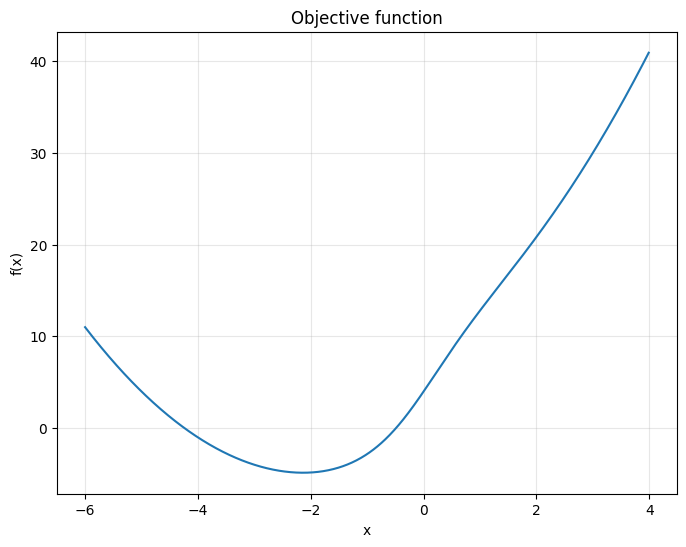

In [23]:
def f(x):
    return (x + 2)**2 + 5*jnp.tanh(x)

args = np.arange(-6,4,0.01)
plt.figure(figsize=(8,6))
plt.plot(args, f(args))
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Objective function')
plt.grid(alpha=0.3)
plt.show()

Converged after 57 iterations.
optimal x: -2.135782
optimal value of f(x): -4.8438854


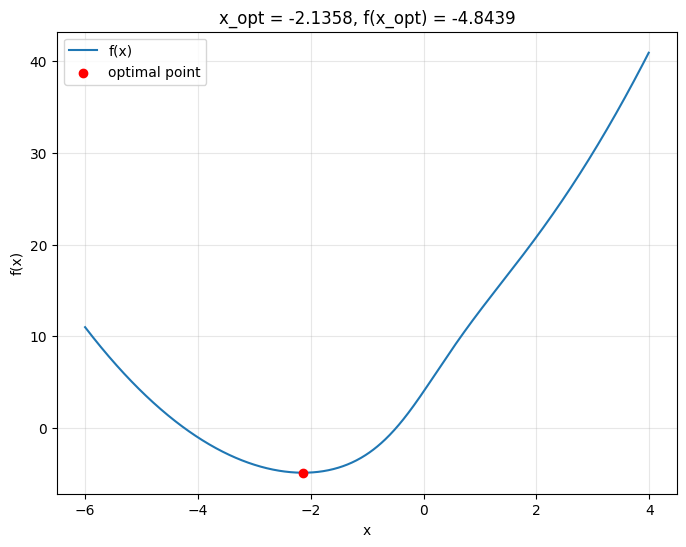

In [24]:
def minimize_with_gradient_descent(func, initial_guess, step_size, convergence_tol=1e-8):
    '''
    Minimizes a scalar function of a single variable.
    Inputs:
        func              : name of function to be optimized. Takes initial_guess as input.
        initial_guess     : a real number
        convergence_tol   : convergence tolerace; when current and next guesses of of optimal x are closer
                            together than this, algorithm terminates and returns current estimate of optimal x

    Outputs:
        x_k1 : current best estimate of x which minimizes f(x)
    '''
   
    x_k1 = jnp.array(initial_guess)
    grad_func = jax.grad(func)
    
    for i in range(1000):  # max iterations
        gradient = grad_func(x_k1)
        x_k2 = x_k1- step_size*gradient

        if jnp.abs(x_k2 - x_k1) < convergence_tol:
            print(f"Converged after {i} iterations.")
            break

        x_k1 = x_k2

    return x_k1 # update this line
        
# Test the function

x_opt = minimize_with_gradient_descent(f, 5.0, 0.1)


# output and plot:
print('optimal x:', x_opt)
print('optimal value of f(x):', f(x_opt))

args = np.arange(-6,4,0.01)
plt.figure(figsize=(8,6))
plt.plot(args, f(args), label='f(x)')
plt.scatter(x_opt, f(x_opt), zorder=2, color='red', label='optimal point')
plt.title('x_opt = {:.4f}, f(x_opt) = {:.4f}'.format(x_opt, f(x_opt)))
plt.grid(alpha=0.3)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()


### (b) Applying log-barrier for solving constrained optimization problems
Now suppose we want to add a _constraint_ to our optimization problem; that is, a restriction on the set of $x$ values we'll consider acceptable. In particular, in this case we'll say that we only want values of $x$ such that, for some specified _constraint function_ $g(x)$, we have $g(x) < 0$; this is called an _inequality constraint_.

The gradient descent algorithm described above has no way to enforce a constraint like this; $x$ is allowed to wander wherever the gradient takes it. Thus we must modify the algorithm to allow it to find constrained optima under inequality constraints. There are several ways to do this, but in this problem we will be using the _log-barrier method_. 

In this method, we construct from the objective function $f(x)$ a different objective function $\phi (x)$ that has the following properties:
 - When $x$ is such that $g(x)$ is far away from $0$, then $\phi(x)$ must approximate $f(x)$, so that minimizing $\phi(x)$ approximately minimizes $f(x)$.
 - $\phi(x)$ must grow to infinity as $g(x)$ approaces $0$. This will prevent $x$ from crossing over the boundary of $g(x) < 0$.

To accomplish these goals, we construct $\phi(x)$ like so:
$$
\phi(x) = f(x) - t\ln(-g(x)),
$$
where $t$ is a weighting parameter that we choose.

Suppose we want to minimize the same objective function as before, $f(x) = (x + 2)^2 + 5\tanh (x)$, but now we want a constraint $x > 1$. In the code block below, fill out the functions `g` and `phi`. The starter code will plot $f(x)$, as well as $\phi(x)$ for $t = 0.5,\ 2,\ 5$. Comment on how $\phi(x)$ changes with changing $t$. Note that since $\ln(y)$ is not defined (in the real numbers) for $y \le 0$, the domain of $\phi(x)$ is restricted to $x > 1$.

Hint: for your `phi` function to work well with the next parts of this problem, be sure to use `jnp.log` instead of `np.log`.

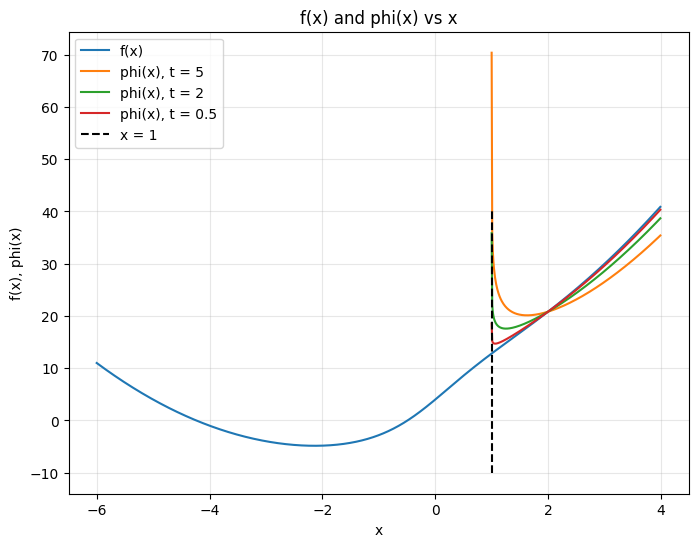

In [25]:
# fill out g(x) so that the statement g(x) < 0 is equivalent to the statement x > 1
def g(x):
    return 1 - x

def phi(f, x, g, t):
    '''
    Computes phi(x).
    Inputs:
        f  : name of f(x) function; takes x as input
        x  : variable to be optimized
        g  : constraint function; we want to ensure g(x) <= 0
        t  : log-barrier weighting parameter

    Outputs:
        phi(x) 
    '''
    
    '''
    fill code here
    '''
    
    return f(x) - (t)*jnp.log(-g(x)) # update this line

x_upper = 4
dx = 0.01
f_x_domain = np.arange(-6, x_upper, dx)
phi_x_domain = np.arange(1.00001, x_upper, dx)

plt.figure(figsize=(8,6))
plt.plot(f_x_domain, f(f_x_domain), label='f(x)')
plt.plot(phi_x_domain, phi(f, phi_x_domain, g, 5), label='phi(x), t = 5')
plt.plot(phi_x_domain, phi(f, phi_x_domain, g, 2), label='phi(x), t = 2')
plt.plot(phi_x_domain, phi(f, phi_x_domain, g, 0.5), label='phi(x), t = 0.5')
plt.vlines(1, -10, 40, linestyles='dashed', label='x = 1', color='black')
plt.xlabel('x')
plt.grid(alpha=0.3)
plt.ylabel('f(x), phi(x)')
plt.title('f(x) and phi(x) vs x')
plt.legend(loc='upper left')
# plt.ylim(-10, 40)
plt.show()

# The barrier term becomes steep as x → 1⁺, penalizing any solution too close to the constraint boundary.


### (c)
Now, we can use our `minimize_with_gradient_descent` function to minimize $\phi(x)$ instead of $f(x)$. Do so below, for a few different values of $t$, and comment on the results. The true constrained optimal point is $x^* = 1$, $f(x^*) = 12.808$. 

- Does the log-barrier method find the true constrained optimal point? 
- How does the point found by the log-barrier method change as you change $t$? 

You may find that as you decrease $t$, you also need to decrease the gradient descent step size to get good behavior (in particular, to avoid "overshooting" the constraint and finding an $x^*$ estimate which does not respect the constraint). Also, for the log-barrier method to work, your initial guess must itself respect the constraint (in this case, your initial guess must be greater than one).

Hint: the `minimize_with_gradient_descent` function requires an objective function that takes only $x$ as an argument: $f(x)$. But our `phi` Python function defined above takes `f`, `x`, `g`, and `t`; you may find Python's "lambda function" capabilities useful or the `functools.partial`.

In [26]:
# ========================== hint: lambdas ==============================

#def hint_func(arg1, arg2, arg3):
#   return arg1 + 2 * arg2 + arg3

#def hint_func_caller(func, arg):
#    return func(arg)

#foo = 42
#bar = 100

#lambda x: hint_func(foo, x, bar) # this essentially defines a function of x only, that calls hint_func(x, 42, 100)

# hint_func_caller expects a function that takes only one argument. But we can use a lambda expression to
# "prepopulate" all but one argument of hint_func, "turning it into" an argument of one function:

#hint_func_caller(lambda x: hint_func(foo, x, bar), 5) # this will work and give 152

# ^^^^^^^^^^^^^^^^^^^^^^^^^^ hint: lambdas ^^^^^^^^^^^^^^^^^^^^^^^^^^

# ========================== hint: functools.partial ==============================

#new_func = functools.partial(hint_func, foo, arg3=bar) # this is equivalent to lambda x: hint_func(foo, x, bar)
#new_func(5) # this will give 152

# OR

#new_func = functools.partial(hint_func, arg1=foo, arg3=bar) # this is equivalent to lambda x: hint_func(foo, x, bar)
#new_func(arg2=5) # this will give 152

# ^^^^^^^^^^^^^^^^^^^^^^^^^^ hint: functools.partial ^^^^^^^^^^^^^^^^^^^^^^^^^^

# add you code here

# Define the phi wrapper in the hint_func style
def phi_func_wrapper(f_arg, g_arg, t_arg):
    return lambda x: phi(f_arg, x, g_arg, t_arg)

# Set common parameters
f_arg = f            # Original objective function
g_arg = g            # Constraint function g(x) < 0 -> x > 1
initial_guess = 2.0  # Must be > 1 to satisfy constraint
step_size = 0.1

# Different t values for the log barrier
t_values = [10.0, 5.0, 2.0, 1.0, 0.5, 0.1]

# Evaluate and print f(x) at x = 1 (constraint boundary)
x_constraint_boundary = 1.0
f_at_boundary = f(x_constraint_boundary)
print(f"f(x) at constraint boundary x = {x_constraint_boundary}: {f_at_boundary:.6f}\n")

# Run minimization for each t
for t_arg in t_values:
    phi_func = phi_func_wrapper(f_arg, g_arg, t_arg)
    x_phi_opt = minimize_with_gradient_descent(phi_func, initial_guess, step_size)
    
    print(f"Results for t = {t_arg}")
    print("Minimizer of phi(x):", x_phi_opt)
    print("Value of phi(x):", phi(f, x_phi_opt, g, t_arg))
    print("Original f(x) at optimum:", f(x_phi_opt))
    print("-" * 40)

f(x) at constraint boundary x = 1.0: 12.807971

Converged after 3 iterations.
Results for t = 10.0
Minimizer of phi(x): 2.1646776
Value of phi(x): 20.69005
Original f(x) at optimum: 22.214493
----------------------------------------
Converged after 14 iterations.
Results for t = 5.0
Minimizer of phi(x): 1.6273335
Value of phi(x): 20.117338
Original f(x) at optimum: 17.785954
----------------------------------------
Results for t = 2.0
Minimizer of phi(x): 2.126153
Value of phi(x): 21.647207
Original f(x) at optimum: 21.884823
----------------------------------------
Converged after 54 iterations.
Results for t = 1.0
Minimizer of phi(x): -2.259945
Value of phi(x): nan
Original f(x) at optimum: -4.8247004
----------------------------------------
Converged after 55 iterations.
Results for t = 0.5
Minimizer of phi(x): -2.198362
Value of phi(x): nan
Original f(x) at optimum: -4.838975
----------------------------------------
Converged after 55 iterations.
Results for t = 0.1
Minimizer of ph

In [27]:
'''
To ensure that the optimized value x_phi_opt never violates the constraint 𝑥>1
we can dynamically decrease the step size as the log-barrier weight t decreases. 
This helps gradient descent take smaller, safer steps near the boundary."
'''
# Different t values for the log barrier (larger to smaller)
t_values = [10.0, 5.0, 2.0, 1.0, 0.5, 0.1]
step_size = [0.05, 0.05, 0.05, 0.02, 0.02, 0.01]
# Evaluate and print f(x) at x = 1 (constraint boundary)
x_constraint_boundary = 1.0
f_at_boundary = f(x_constraint_boundary)
print(f"f(x) at constraint boundary x = {x_constraint_boundary}: {f_at_boundary:.6f}\n")

# Run minimization for each t
for t_arg, step in zip(t_values, step_size):
    #step_size = 0.2 * jnp.exp(-t_arg)
    phi_func = phi_func_wrapper(f_arg, g_arg, t_arg)
    x_phi_opt = minimize_with_gradient_descent(phi_func, initial_guess, step)
    
    print(f"Results for t = {t_arg}")
    print("Minimizer of phi(x):", x_phi_opt)
    print("Value of phi(x):", phi(f, x_phi_opt, g, t_arg))
    print("Original f(x) at optimum:", f(x_phi_opt))
    print("-" * 40)

f(x) at constraint boundary x = 1.0: 12.807971

Converged after 24 iterations.
Results for t = 10.0
Minimizer of phi(x): 2.1646776
Value of phi(x): 20.69005
Original f(x) at optimum: 22.214493
----------------------------------------
Converged after 15 iterations.
Results for t = 5.0
Minimizer of phi(x): 1.6273336
Value of phi(x): 20.117336
Original f(x) at optimum: 17.785954
----------------------------------------
Results for t = 2.0
Minimizer of phi(x): 1.2531356
Value of phi(x): 17.576355
Original f(x) at optimum: 14.828694
----------------------------------------
Converged after 17 iterations.
Results for t = 1.0
Minimizer of phi(x): 1.1253942
Value of phi(x): 15.891568
Original f(x) at optimum: 13.815275
----------------------------------------
Results for t = 0.5
Minimizer of phi(x): 1.099224
Value of phi(x): 14.761478
Original f(x) at optimum: 13.606291
----------------------------------------
Converged after 515 iterations.
Results for t = 0.1
Minimizer of phi(x): -2.1483717
V

## Problem 4 (`cvxpy`)

In this problem we will explore the basics of `cvxpy`, a Python package for solving convex optimization problems. `cvxpy` has a good tutorial [here](https://www.cvxpy.org/tutorial/intro/index.html), so read that page before proceeding with this problem (the section on "parameters", while useful, is not important for this homework, so consider that section optional for now).


Consider a vector variable $x = [x_1,  x_2,  x_3]^T$. Use `cvxpy` to compute the minimizer of the following objective function
$$
x_1^2 + 2x_2^2 + 3.5x_3^2,
$$

subject to the constraint

$$
\begin{bmatrix}
0.707 & 0.707 & 0 \\
-1 & 0 & 0 \\
0 & -1 & 0 \\
0 & 0 & -1
\end{bmatrix}x \le \begin{bmatrix}
2 \\
-1 \\
-1 \\
-3
\end{bmatrix}.
$$

Print the optimal $x$ and the optimal value of the objective function.

Notice how much easier it is to use `cvxpy` than to write our own optimization algorithm from scratch!

In [28]:
# add you code here

# Define the matrix A
A = np.array([
    [0.707, 0.707, 0],
    [-1,  0,  0],
    [0,  -1,  0],
    [0,  0,  -1]])
    
# Define the right-hand side vector b
b = np.array([2, -1, -1, -3])

# Construct the problem.
n = 3
x = cp.Variable(n)
objective = cp.Minimize(x[0]**2 + 2*x[1]**2 + 3.5*x[2]**2)
constraints = [A @ x <= b]
prob = cp.Problem(objective, constraints)

print("Optimal objective value", prob.solve())
print("Optimal variable value")
print(x.value) # A numpy ndarray.

Optimal objective value 34.5
Optimal variable value
[1. 1. 3.]


## Problem 5 (Control Barrier Function and CBF-QP)

In this problem, using the concepts and code you have developed in the previous problems, you will implement a CBF-QP safety filter.
We will restrict ourselves to a simple 1D system so that you can verify your results analytically if needed, but note that the theory extends to higher dimensional problems, and try to keep your code general so that it could still work on a different system and choice of CBF.

Consider the following 1D single integator dynamics $ \dot{x} = u $ and let $b(x) = x^2 - 1$.

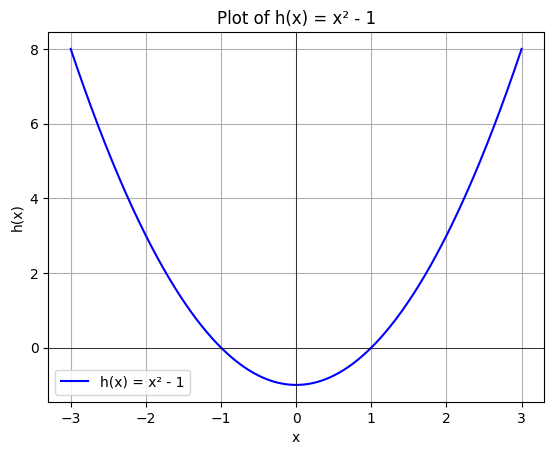

In [33]:
# Define the function
def h(x):
    return x**2 - 1

# Generate x values
x = np.linspace(-3, 3, 400)  # from -3 to 3 with 400 points

# Compute y values
#y = h(x)

# Plot the function
plt.plot(x, h(x), label='h(x) = x² - 1', color='blue')
plt.axhline(0, color='black', linewidth=0.5)  # x-axis
plt.axvline(0, color='black', linewidth=0.5)  # y-axis
plt.title('Plot of h(x) = x² - 1')
plt.xlabel('x')
plt.ylabel('h(x)')
plt.grid(True)
plt.legend()
plt.show()

### (a) Computing the Lie derivative
What is the expression for $\nabla b(x)^T f(x,u)$?

$\nabla b(x) = \frac{\partial{b}}{\partial{x}} =   2x$

$\dot{x} = f(x,u) = u$

$\nabla b(x)^Tf(x,u) = (2x)^{T}u = 2xu$

In [35]:
# The Lie derivative can also be computed using the script below:

import sympy as sp
# Define symbolic variables
x, u = sp.symbols('x u')

# Define the barrier function and dynamics
b = x**2 - 1
f = u  # since dx/dt = u

# Compute gradient of b(x)
grad_b = sp.diff(b, x)

# Compute Lie derivative: grad_b * f
lie_derivative = grad_b * f

# Display results
print("b(x) =", b)
print("∇b(x) =", grad_b)
print("f(x,u) =", f)

b(x) = x**2 - 1
∇b(x) = 2*x
f(x,u) = u


### (b) Solving the CBF-QP
Suppose that your desired control is $u_\mathrm{des}=0.5$, which is to move in the positive $x$-direction at constant velocity. But the safety filter enforces that $x^2 \geq 1$, i.e., keep a 1 unit away from the origin.

The CBF safety filter essentially chooses a control input that is as close to $u_\mathrm{des}$ as possible while satisfying the CBF inequality constraint.

$$
u_\mathrm{safe}(x) = \underset{u}{\text{argmax}} \| u - u_\mathrm{des}\|_2^2 \:\: \text{subj. to} \:\: \nabla b(x)^Tf(x,u) \geq -\alpha(b(x))
$$

This is referred to as the CBF-QP since it is a quadratic program (quadratic objective and linear constraints). For simplicity, we assume there are no other constraints on controls.

Let $\alpha(z) = az$, $a=0.5$
Use `cvxpy` to solve the CBF-QP for $x=-3$, $x=-2$ and $x=-1.1$.

Report the corresponding safe control values.

Hint: You may find the `Parameter` variable in `cvxpy` helpful. It allows you to update certain parameters without needing to reconstruct the optimization each time.




In [29]:
'''The expression {\text{argmax}} \| u - u_\mathrm{des}\|_2^2
  is the squared L2 norm of the difference between the variable 
u and the desired value u_des. Typically, we would minimize this norm to find a solution that gets as close as possible to u_des,
but we want to maximize this expression.

Maximizing the expression is equivalent to minimizing the negative of the norm:

'''
# add you code here
# Construct the problem.
n = 1
u = cp.Variable(n)
u_des = 0.5
x_param = cp.Parameter()  # This is a cvxpy parameter
a = 0.5 
# The control barrier function b(x) = x^2 - 1
bx = x_param**2 - 1

# The gradient of b(x)
grad_bx = 2*x_param

# dynamics
fx = u

# cbf constraint
cbf_constraint = grad_bx*fx >= -a*bx

# Objective: maximize the squared L2 norm, which is equivalent to minimizing the negative of the norm
objective = cp.Minimize(cp.square(u-u_des))
constraints = [cbf_constraint]
prob = cp.Problem(objective, constraints)

# Loop through different values of x and solve using CVXPY
x = [-3, -2, -1.1]
for x_value in x:
    # Update the parameter with the current x value
    x_param.value = x_value
    
    # Solve the problem
    prob.solve()
    
    # Output the results for the current value of x
    print({prob.status})
    print(f"Results for x = {x_value}")
    print(f"Optimal control input (u): {u.value}")
    print(f"Objective value (maximized squared error): {prob.value}")
    print("-" * 40)

{'optimal'}
Results for x = -3
Optimal control input (u): [0.5]
Objective value (maximized squared error): 1.232595164407831e-32
----------------------------------------
{'optimal'}
Results for x = -2
Optimal control input (u): [0.375]
Objective value (maximized squared error): 0.015625
----------------------------------------
{'optimal'}
Results for x = -1.1
Optimal control input (u): [0.04772727]
Objective value (maximized squared error): 0.20455061983471068
----------------------------------------


c:\Users\Tatiana\Documents\lmc_uw\.venv\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:241: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


### (c) Applying the CBF safety filter
Now, simulate the system starting from $x=-5$ and with $u_\mathrm{des}=0.5$, but the CBF safety filter is applied. Plot the state and control sequence for $a=2$, $a=1$, $a=0.5$ and $a=0.1$ where $\alpha(z) = az$. 
Comment on how the trajectory changes as $a$ changes. What is your interpretation of $a$?

Use $\Delta t = 0.05$ and simulate for 500 steps.

Note that the CBF theory is for continuous-time dynamics, but when we simulate, we use discrete-time dynamics. There are some practical issues that we need to be careful about (see [this paper](https://arxiv.org/abs/2404.12329) for more details), but right now, let's stick to using a reasonably small time step.



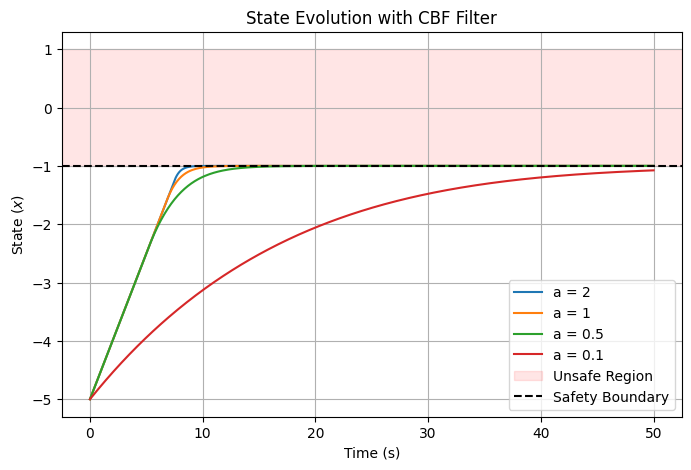

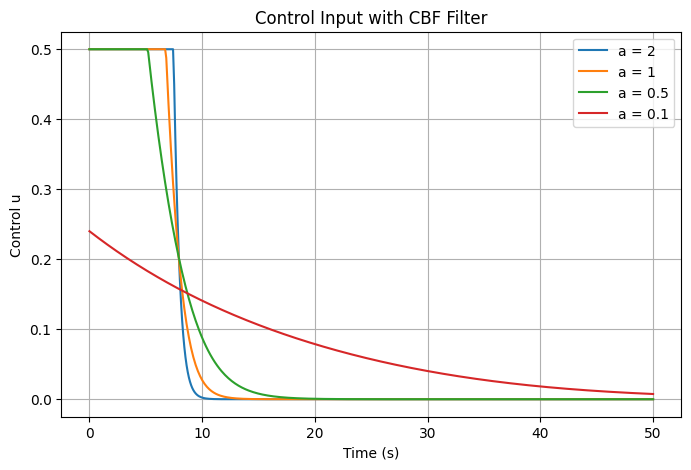

"Comment: as 'a' increases, it allows the system to get closer to the boundary of the safe set in this case x >1,   \nalso u is closer to the u_des = 0.5, not sure if these results make sense, as I would expect that as 'a' increases,    \nthe system is more conservative, hence moves further from the boundary x >= -1. \n"

In [42]:
# add you code here
# define continuous-time dynamics
#def dynamics(x, u):
#    return u  # Simple dynamics xdot = u

# construct discrete-time dynamics
def dynamics_discrete(x, u, dt):
    return x + dt * u  # Discrete-time update: x_k+1 = x_k + u_k * dt

def cbf_qp(x,u_des,a):
    u = cp.Variable(name='u')
    # Define CBF constraint  (derived from Lie derivative condition)
    constraint = [2 * x * u >= -a * (x**2 - 1)]
    # Objective function: minimize the deviation from desired control u_des
    objective = cp.Minimize((u - u_des)**2)

    # Solve the quadratic program (CBF-QP) and return safe control input
    prob = cp.Problem(objective, constraint)
    prob.solve()
    return u.value


    # simulate system, during which the CBF-QP safety filter is applied.
def simulate_system(a, u_des=0.5, x0=-5, dt=0.05, steps=500):
    # Time vector
    #time = np.arange(0, steps * dt, dt)
    
    # Initialize state and control sequences
    x_seq = np.zeros(steps+1)
    u_seq = np.zeros(steps)
    
    # Set initial state
    x_seq[0] = x0
    
    # Loop over each time step and apply the CBF safety filter
    for i in range(steps):
            u_safe = cbf_qp(x_seq[i], u_des, a)
            u_seq[i] = u_safe
            
            # Update state based on control input using discrete-time dynamics
            x_seq[i+1] = x_seq[i] + dt * u_safe  # Discrete time update of the state
    
    # Return time, state, and control sequences
    return x_seq, u_seq

# Initial state and control
x0 = -5
u_des = 0.5
a_values = [2, 1, 0.5, 0.1]
steps = 500

# Store results for each a
results = {}
for a in a_values:
    x_seq, u_seq = simulate_system(a, u_des, x0, dt, steps)
    results[a] = (x_seq, u_seq)
    
# Time vectors for plotting
t_state = np.linspace(0, dt*steps, steps+1)
t_control = np.linspace(0, dt*steps, steps)  

# Plot x vs time
plt.figure(figsize=(8, 5))
for a in a_values:
    x_seq, _ = results[a]
    plt.plot(t_state, x_seq, label=f'a = {a}')
plt.axhspan(-1, 1, color='red', alpha=0.1, label='Unsafe Region')
plt.axhline(y=-1, color='k', linestyle='--', label='Safety Boundary')
plt.xlabel('Time (s)')
plt.ylabel('State ($x$)')
plt.title('State Evolution with CBF Filter')
plt.grid(True)
plt.legend()
plt.show()

# Plot u vs time
plt.figure(figsize=(8, 5))
for a in a_values:
    _, u_seq = results[a]
    plt.plot(t_control, u_seq, label=f'a = {a}')
plt.xlabel('Time (s)')
plt.ylabel('Control u')
plt.title('Control Input with CBF Filter')
plt.grid(True)
plt.legend()
plt.show()

'''Comment: as 'a' increases, it allows the system to get closer to the boundary of the safe set in this case x >1,   
also u is closer to the u_des = 0.5, not sure if these results make sense, as I would expect that as 'a' increases,    
the system is more conservative, hence moves further from the boundary x >= -1. 
'''

### Comment on how the trajectory changes as $a$ changes. What is your interpretation of $a$?

Looking at the trajectory plot, we can see that with the smallest $a$ value of 0.1, the system never actually reaches the safe boundary within the 500 simulation steps. At $a$ = 0.5, we can see that the system hits the safety boundary in about 15 seconds. From there, increasing $a$ to 1 and then to 2 results in only marginal improvements in convergence time, suggesting that small increases in $a$ can yield large performance gains, but there's diminishing return beyond a certain point. Observing the control input plot, we can see that for larger alpha values, the controller holds at 0.5 until the last moment, then plunges almost vertically to enforce safety, wehereas for smaller alpha values, the control input gradually decays. 

We can interpret $a$ as the parameter that regulates how gently or aggressively the barrier constraint is enforced, influencing the system’s responsiveness in approaching the boundary. 

A larger $a$ is seen to be more aggressive, we mnaintain the desired control $( u_{\text{des}} = 0.5 )$ until nearly reaching the safety boundary, and then the suddenly, the control sequence drops sharply to avoid the unsafe region. 

A smaller $a$ is seen to be more conservative. We dont reach the safety boundary as quickly and sacrifice performance earlier on so that the approach to the safety boundary is more smooth and gradual. 

For applications, we need to consider the trade-off's between smaller and larger alpha values depending on how long we want to maintain the desired control and reach a boundary, or if we want a more gradual and robust approach, but at a slower rate. The following papers go into the practical applications and consideration of alpha for specific systems: [here](https://www.mdpi.com/2079-9292/11/22/3657) and [here](https://arxiv.org/abs/2201.01347)
